<a href="https://colab.research.google.com/github/kretchmar/CS339_2023/blob/main/KNN_Fisher_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Research Part II

Phineas Pham <P>
Feb 2023 <P>
 

### Import libraries:

In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets   #only for the purposes of loading the iris dataset
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from PIL import Image
from scipy import linalg as la
#classification report
from sklearn.metrics import classification_report
from collections import Counter
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier

#stop warnings
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [38]:
def k_means(df, k, max_iter=100):
    """K-Means clustering algorithm.

    Args:
        df (dataframe): training data
        k (int): number of clusters 
        max_iter (int, optional): number of maximum iterations before halting. Defaults to 100.

    Returns:
        l_centers (list): list of centers changes over time
        time_to_converge (int): time taken to converge
        mse (list): list of mean squared error over time
        df['cluster'] (list): cluster index of each point
    """
    #initialize centers
    #randomly choose k points as centers
    centers = resample(df, 
                        replace=True,     
                        n_samples=k,    
                        random_state=3)
    mse = []
    l_centers = []
    time = max_iter
    while(time > 0):
        time -= 1
        # assign each point to the nearest center (cluster index)
        df['cluster'] = df.apply(lambda x: np.argmin(np.sum((centers - x)**2, axis=1)), axis=1)

        #calculate mse
        temp_mse = []
        for i in df['cluster']:
            temp_mse.append(np.sum(np.sum((df.loc[df['cluster'] == i] - centers.iloc[i])**2, axis=1)))
        mse.append(sum(temp_mse)/len(df.index))
        
        #adjust centers
        new_centers = df.groupby('cluster').mean()

        # check if centers are the same, then stop
        if np.all(centers.equals(new_centers)):
            break
        centers = new_centers
        l_centers.append(centers)

    time_to_converge = max_iter - time - 1
    mse.pop()   # remove the last mse, which is repeated
    
    return l_centers, time_to_converge, mse, df['cluster']

In [39]:
def elbowGraph(df, max_k):
    """Plot the elbow graph to find the optimal k.
    """
    mse_list = []
    k_list = []
    for i in range(max_k):
        k = i+1
        l_centers, time_to_converge, mse, df['cluster'] = k_means(df, k)
        mse_list.append(mse[-1])
        k_list.append(k)
        plt.plot(k, mse[-1], 'bx')
    plt.xlabel('k')
    plt.ylabel('MSE')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    return k_list, mse_list

### Load Bobolink and Yellowthroat images

In [40]:
#Define some parameters for the loader:
batch_size = 32
img_height = 200
img_width = 200

In [41]:
data = np.zeros((120,562500))    #10304*6
labels = [] # 0 for bobolink, 1 for yellowthroat

# get path of the dataset
pwd_add = os.getcwd()

# read 60 images of bobolinks
for i in range(60):
    filename = 'bobolink{0:d}.jpg'.format(i+1)
    #print('loading: ',filename)
    im = Image.open(pwd_add+'/dataset/'+filename)
    #resize images to 750*750
    im_resized = im.resize((750, 750))
    im_resized.save(pwd_add+'/dataset/'+filename)
    im = Image.open(pwd_add+'/dataset/'+filename)
    im = im.convert("L")    #convert to grayscale
    a = np.asarray(im)
    a = a.reshape(750*750)
    data[i,:] = a.astype(float)
    labels.append(0)
    
# read 60 images of yellowthroats
for i in range(60):
    filename = 'yellowthroat{0:d}.jpg'.format(i+1)
    #print('loading: ',filename)
    im = Image.open(pwd_add+'/dataset/'+filename)
    #resize images to 750*750
    im_resized = im.resize((750, 750))
    im_resized.save(pwd_add+'/dataset/'+filename)
    im = Image.open(pwd_add+'/dataset/'+filename)
    im = im.convert("L")    #convert to grayscale
    a = np.asarray(im)
    a = a.reshape(750*750)
    data[i+60,:] = a.astype(float)
    labels.append(1)

In [42]:
def showImage (im):
  im = im.reshape((750,750))
  plt.imshow(im,cmap='gray')

Image of bobolink (#0)
Image of bobolink (#59)
Image of yellowthroat (#60)
Image of yellowthroat (#120)


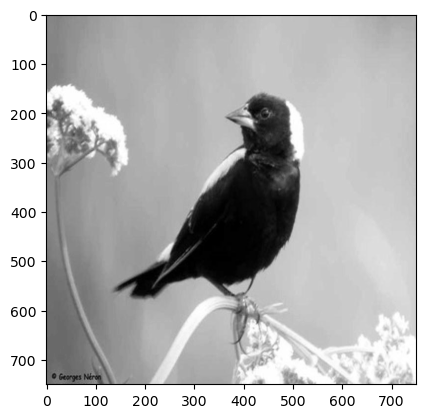

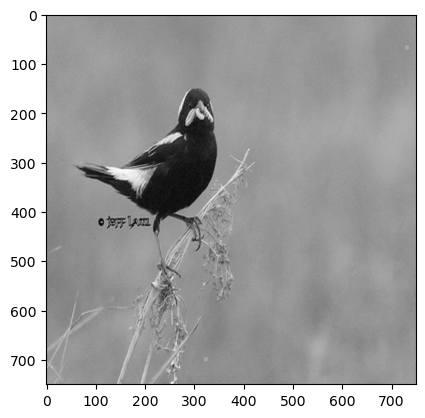

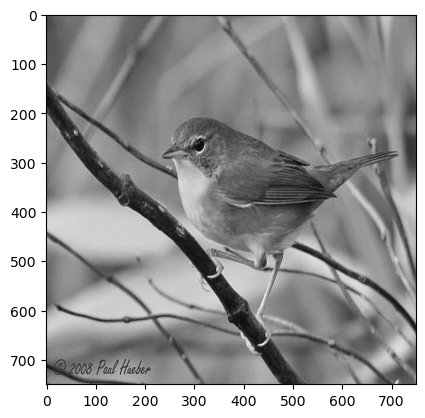

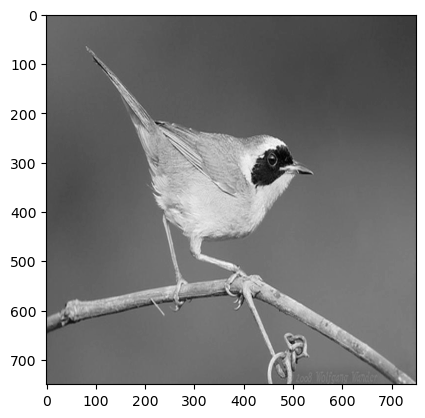

In [43]:
print("Image of bobolink (#0)")
plt.figure(0)
showImage(data[0,:])

print("Image of bobolink (#59)")
plt.figure(1)
showImage(data[59,:])

print("Image of yellowthroat (#60)")
plt.figure(2)
showImage(data[60,:])

print("Image of yellowthroat (#120)")
plt.figure(3)
showImage(data[-1,:])


In [44]:
label_df = pd.DataFrame(labels)

Split dataset into training and testing sets

In [45]:
# Splitting the X and Y into the
# Training set and Testing set
from sklearn.model_selection import train_test_split
  
X_train, X_test, y_train, y_test = train_test_split(data, label_df, test_size = 0.25, random_state = 0)

Perform standardization

In [46]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Then, we use PCA to find principal components

In [47]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 2)
  
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

In [48]:
principalDf = pd.DataFrame(data = X_train, columns = ['principal component 1', 'principal component 2'])
#finalDf is the training dataset with the principal components and the labels
finalDf = pd.concat([principalDf, pd.DataFrame(y_train).reset_index()], axis = 1)
finalDf = finalDf.drop(['index'], axis=1)
finalDf = finalDf.rename(columns={0: "label"})

principal_testDf = pd.DataFrame(data = X_test, columns = ['principal component 1', 'principal component 2'])
#testDf is the test dataset with the principal components and the labels
testDf = pd.concat([principal_testDf, pd.DataFrame(y_test).reset_index()], axis = 1)
testDf = testDf.drop(['index'], axis=1)
testDf = testDf.rename(columns={0: "label"})

<AxesSubplot: xlabel='principal component 1', ylabel='principal component 2'>

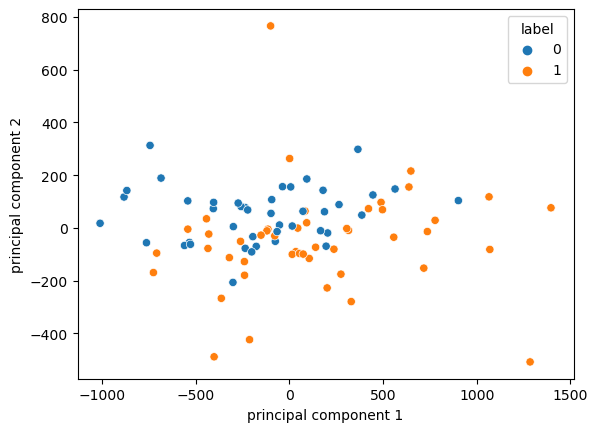

In [49]:
#Plot PCA result
sns.scatterplot(data=finalDf,x='principal component 1',y='principal component 2',hue='label')
 

## K-means:

Fit on training dataset:

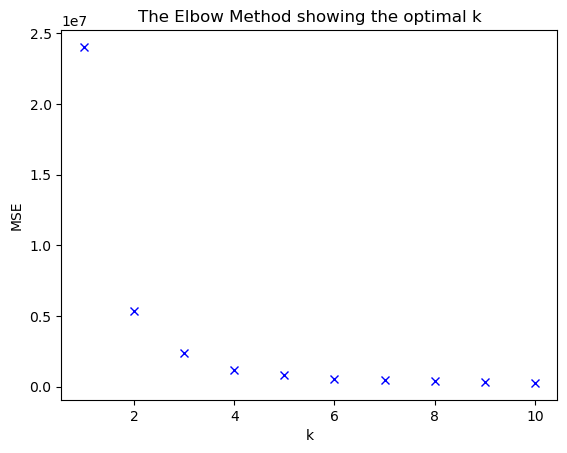

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [24020984.982186843,
  5331162.058870633,
  2358418.30701562,
  1219103.211686409,
  855621.0895176658,
  560823.5506006328,
  461955.6980988001,
  382600.4171532257,
  303854.2608866517,
  272844.53914440155])

In [50]:
elbowGraph(finalDf[['principal component 1', 'principal component 2']], 10)

In [51]:
l_centers, t, mse, list_of_cluster = k_means(finalDf[['principal component 1',	'principal component 2']], 4, max_iter=100)

<AxesSubplot: xlabel='principal component 1', ylabel='principal component 2'>

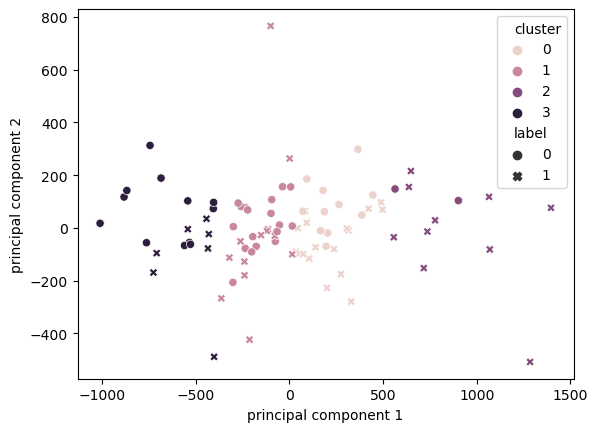

In [52]:
#Plot PCA result
sns.scatterplot(data=finalDf,x='principal component 1',y='principal component 2',hue=list_of_cluster, style='label')

Cluster 1 and 3 are closer to label 0, while cluster 0 and 4 are closer to label 1

<AxesSubplot: xlabel='principal component 1', ylabel='principal component 2'>

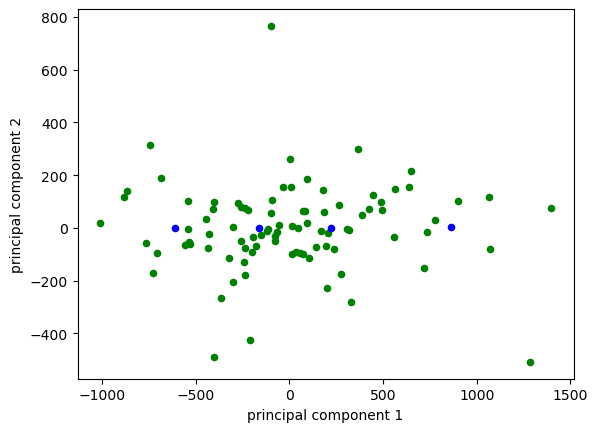

In [53]:
# open figure/axis
fig, ax = plt.subplots()


finalDf.plot(x='principal component 1', y='principal component 2', kind='scatter', ax=ax, c='g')
l_centers[-1].plot(x=0, y=1, kind='scatter', ax=ax, c='b')

<AxesSubplot: xlabel='principal component 1', ylabel='principal component 2'>

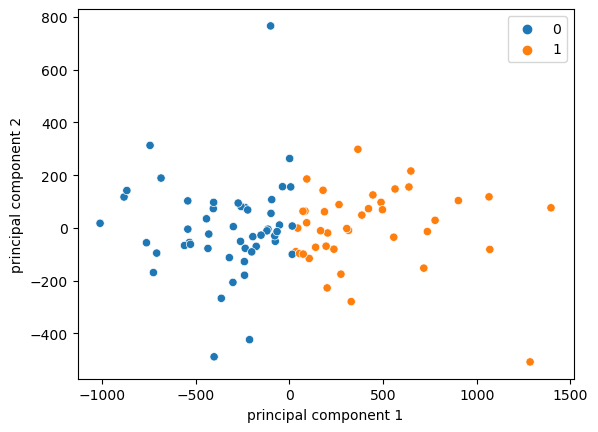

In [54]:
k_4_kmeans_prediction = [0 if i in (3,1) else 1 for i in list_of_cluster]

#Plot PCA result
sns.scatterplot(data=finalDf,x='principal component 1',y='principal component 2',hue=k_4_kmeans_prediction)

In [55]:
# assign each point to the nearest center (cluster index)
preds = testDf.apply(lambda x: np.argmin(np.sum((l_centers[-1] - x)**2, axis=1)), axis=1)
adjusted_preds = [0 if i in (3,1) else 1 for i in preds]

In [56]:
print(classification_report(testDf[['label']], adjusted_preds))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55        17
           1       0.43      0.46      0.44        13

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.49        30
weighted avg       0.50      0.50      0.50        30



## KNN:

Here, we train KNN on training dataset and fit the model on testing set

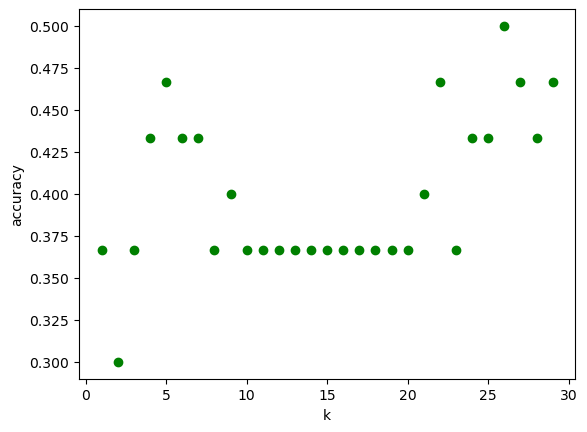

In [57]:
X, Y = [], []
for k in range(1, 30):
    classifier = KNeighborsClassifier(n_neighbors=k, 
                                      metric="euclidean")
    classifier.fit(X_train, y_train)

    #predict on test set
    predictions = classifier.predict(X_test)
    score = accuracy_score(y_test, predictions)


    X.append(k)
    Y.append(score)
    
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.plot(X, Y, "go")

In [60]:
# kNN algorithm with k = 26 and use Euclidean metric
knn = KNeighborsClassifier(n_neighbors=26, metric="euclidean")
knn.fit(X_train,y_train)

predictions = knn.predict(X_test)
# Report key metrics
print(sklearn.metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52        17
           1       0.44      0.54      0.48        13

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.51      0.50      0.50        30

